In [69]:
!pip install python-igraph[all]

In [70]:
import pandas as pd
import numpy as np
import igraph
from igraph import Graph, EdgeSeq


# Abre el archivo
with open('AtributosJuego.txt', 'r') as archivo:

    # Lee el contenido del archivo
    contenido = archivo.read()

    # Separa los strings por comas y guárdalos en una lista
    atributos = contenido.split(',')

# Cierra el archivo
archivo.close()
dataset= pd.read_csv("Juego.txt", sep= ",",names=atributos, decimal=',', header=None)


dataset.head()


,TiempoExterior,Temperatura,Humedad,Viento,Jugar
0,soleado,caluroso,alta,falso,no
1,soleado,caluroso,alta,verdad,no
2,nublado,caluroso,alta,falso,si
3,lluvioso,templado,alta,falso,si
4,lluvioso,frio,normal,falso,si


In [71]:
#Calcula la entropía total del dataset
def calc_total_entropy(datos, decisión, class_list):
    total_row = datos.shape[0] #the total size of the dataset
    total_entr = 0
    
    for c in class_list: #for each class in the decisión
        total_class_count = datos[datos[decisión] == c].shape[0] #number of the class
        total_class_entr = - (total_class_count/total_row)*np.log2(total_class_count/total_row) #entropy of the class
        total_entr += total_class_entr #adding the class entropy to the total entropy of the dataset
    
    return total_entr

In [72]:
#Calcula la entropía de la class list data
def calc_entropy(feature_value_data, label, class_list):
    class_count = feature_value_data.shape[0]
    entropy = 0
    
    for c in class_list:
        label_class_count = feature_value_data[feature_value_data[label] == c].shape[0] #row count of class c 
        entropy_class = 0
        if label_class_count != 0:
            probability_class = label_class_count/class_count #probability of the class
            entropy_class = - probability_class * np.log2(probability_class)  #entropy
        entropy += entropy_class
    return entropy

In [73]:
def calc_info_gain(feature_name, train_data, label, class_list):
    feature_value_list = train_data[feature_name].unique() #unqiue values of the feature
    total_row = train_data.shape[0]
    feature_info = 0.0
    
    for feature_value in feature_value_list:
        feature_value_data = train_data[train_data[feature_name] == feature_value] #filtering rows with that feature_value
        feature_value_count = feature_value_data.shape[0]
        feature_value_entropy = calc_entropy(feature_value_data, label, class_list) #calculcating entropy for the feature value
        feature_value_probability = feature_value_count/total_row
        feature_info += feature_value_probability * feature_value_entropy #calculating information of the feature value
        
    return calc_total_entropy(train_data, label, class_list) - feature_info #calculating information gain by subtracting

In [74]:
def find_most_informative_feature(train_data, label, class_list):
    feature_list = train_data.columns.drop(label) #finding the feature names in the dataset
                                            #N.B. label is not a feature, so dropping it
    max_info_gain = -1
    max_info_feature = None
    
    for feature in feature_list:  #for each feature in the dataset
        feature_info_gain = calc_info_gain(feature, train_data, label, class_list)
        if max_info_gain < feature_info_gain: #selecting feature name with highest information gain
            max_info_gain = feature_info_gain
            max_info_feature = feature
            
    return max_info_feature

In [75]:

def generate_sub_tree(feature_name, train_data, label, class_list):
    feature_value_count_dict = train_data[feature_name].value_counts(sort=False) #dictionary of the count of unqiue feature value
    tree = {} #sub tree or node
    
    for feature_value, count in feature_value_count_dict.iteritems():
        feature_value_data = train_data[train_data[feature_name] == feature_value] #dataset with only feature_name = feature_value
        
        assigned_to_node = False #flag for tracking feature_value is pure class or not
        for c in class_list: #for each class
            class_count = feature_value_data[feature_value_data[label] == c].shape[0] #count of class c

            if class_count == count: #count of (feature_value = count) of class (pure class)
                tree[feature_value] = c #adding node to the tree
                train_data = train_data[train_data[feature_name] != feature_value] #removing rows with feature_value
                assigned_to_node = True
        if not assigned_to_node: #not pure class
            tree[feature_value] = "?" #as feature_value is not a pure class, it should be expanded further, 
                                      #so the branch is marking with ?
            
    return tree, train_data

In [76]:
def make_tree(root, prev_feature_value, train_data, label, class_list):
    if train_data.shape[0] != 0: #if dataset becomes enpty after updating
        max_info_feature = find_most_informative_feature(train_data, label, class_list) #most informative feature
        tree, train_data = generate_sub_tree(max_info_feature, train_data, label, class_list) #getting tree node and updated dataset
        next_root = None
        
        if prev_feature_value != None: #add to intermediate node of the tree
            root[prev_feature_value] = dict()
            root[prev_feature_value][max_info_feature] = tree
            next_root = root[prev_feature_value][max_info_feature]
        else: #add to root of the tree
            root[max_info_feature] = tree
            next_root = root[max_info_feature]
        
        for node, branch in list(next_root.items()): #iterating the tree node
            if branch == "?": #if it is expandable
                feature_value_data = train_data[train_data[max_info_feature] == node] #using the updated dataset
                make_tree(next_root, node, feature_value_data, label, class_list) #recursive call with updated dataset

In [77]:
def id3(train_data_m, label):
    train_data = train_data_m.copy() #getting a copy of the dataset
    tree = {} #tree which will be updated
    class_list = train_data[label].unique() #getting unqiue classes of the label
    make_tree(tree, None, train_data, label, class_list) #start calling recursion
    return tree

In [78]:
tree = id3(dataset, 'Jugar')
print(tree)

{'TiempoExterior': {'soleado': {'Humedad': {'alta': 'no', 'normal': 'si'}}, 'nublado': 'si', 'lluvioso': {'Viento': {'falso': 'si', 'verdad': 'no'}}}}


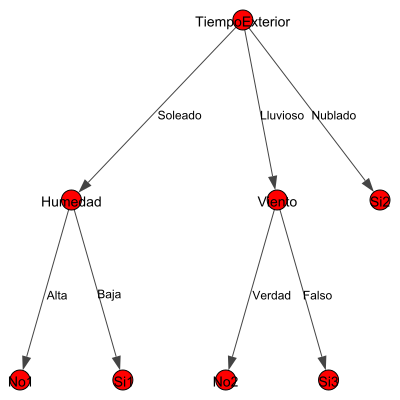

In [91]:
# Crear el grafo
g = igraph.Graph(directed=True)

# Agregar los vértices al grafo
g.add_vertices(["TiempoExterior", "Humedad", "Viento", "No1", "Si1", "Si2", "No2", "Si3"])

# Agregar las aristas al grafo
g.add_edges([("TiempoExterior", "Humedad"), ("TiempoExterior", "Viento"), ("Humedad", "No1"), ("Humedad", "Si1"), ("TiempoExterior","Si2"), ("Viento", "No2"), ("Viento", "Si3")])

# Establecer las etiquetas de las aristas
g.es["label"] = ["Soleado", "Lluvioso", "Alta", "Baja", "Nublado", "Verdad", "Falso"]

# Dibujar el grafo
layout = g.layout("tree")
igraph.plot(g, layout=layout, bbox=(400, 400), margin=20, vertex_label=g.vs["name"], edge_label=g.es["label"])

In [92]:
def predict(tree, instance):
    if not isinstance(tree, dict): #if it is leaf node
        return tree #return the value
    else:
        root_node = next(iter(tree)) #getting first key/feature name of the dictionary
        feature_value = instance[root_node] #value of the feature
        if feature_value in tree[root_node]: #checking the feature value in current tree node
            return predict(tree[root_node][feature_value], instance) #goto next feature
        else:
            return None

In [93]:

def evaluate(tree, test_data_m, label):
    correct_preditct = 0
    wrong_preditct = 0
    for index, row in test_data_m.iterrows(): #for each row in the dataset
        result = predict(tree, test_data_m.iloc[index]) #predict the row
        if result == test_data_m[label].iloc[index]: #predicted value and expected value is same or not
            correct_preditct += 1 #increase correct count
        else:
            wrong_preditct += 1 #increase incorrect count
    accuracy = correct_preditct / (correct_preditct + wrong_preditct) #calculating accuracy
    return accuracy